In [ ]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [1]:
import jax.numpy as jnp
import jax
import optax
import functools

In [276]:
@functools.partial(jax.vmap, in_axes=(None, 0))
def network(params, x):
# make x vectorized and mapped to the network
    return jnp.dot(params, x)

def compute_loss(params, x, y):
    pred = network(params, x)
    loss = jnp.mean(optax.l2_loss(pred, y))
    return loss

In [277]:
key = jax.random.PRNGKey(42)
target_params = jnp.array([0.5, 0.75])

xs = jax.random.normal(key, (16, 2))  # 16 samples of 2D data
ys = jnp.sum(xs * target_params, axis=-1)  # y[i] = x[i,0] * target_params + x[i,1] * target_params

In [278]:
start_learning_rate = 0.1
optimizer = optax.adam(start_learning_rate)

params = jnp.array([0.0, 0.0])
opt_state = optimizer.init(params)

In [132]:
# make grad JITed is faster
@jax.jit
def grad(params, x, y):
    return jax.grad(compute_loss)(params, x, y)

%timeit grad(params, xs, ys).block_until_ready()
%timeit jax.grad(compute_loss)(params, xs, ys).block_until_ready()

19.7 μs ± 1.27 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.63 ms ± 54.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [279]:
ps = []
us = []

for i in range(250):
    grads = grad(params, xs, ys)
    updates, opt_state = optimizer.update(grads, opt_state)
    ps.append(params)
    us.append(updates)
    params = optax.apply_updates(params, updates)

assert jnp.allclose(params, target_params), \
'Optimization should retrieve the target params used to generate the data.'

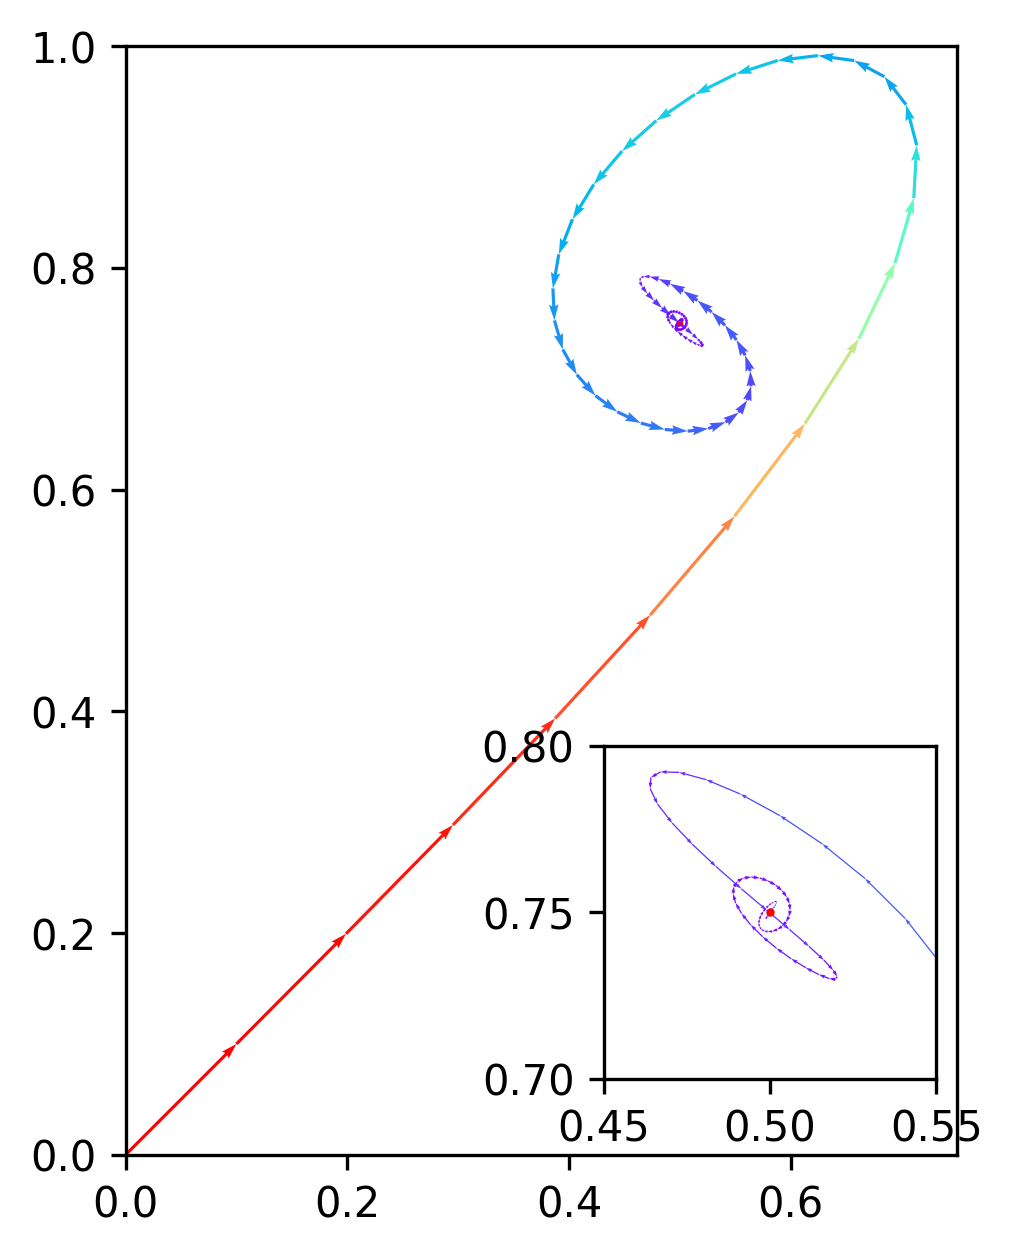

In [280]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import SymmetricalLogLocator
import matplotlib.pyplot as plt

psp = jnp.array(ps)
usp = jnp.array(us)
# Calculate the magnitude of each vector
magnitudes = jnp.linalg.norm(usp, axis=1)

fig1, ax = plt.subplots(dpi=300)
quiver = ax.quiver(psp[:, 0], psp[:, 1], usp[:, 0], usp[:, 1], magnitudes, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
ax.scatter(target_params[0], target_params[1], color='red', s=0.1)
ax.set_xlim(0, 0.75)
ax.set_ylim(0, 1)
ax.set_aspect('equal', adjustable='box')

axins = inset_axes(ax, width="40%", height="40%", loc='lower right')
axins.quiver(psp[:, 0], psp[:, 1], usp[:, 0], usp[:, 1], magnitudes, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
axins.scatter(target_params[0], target_params[1], color='red', s=1)
axins.set_xlim(0.45, 0.55)
axins.set_ylim(0.7, 0.8)
axins.set_aspect('equal', adjustable='box')

plt.show()

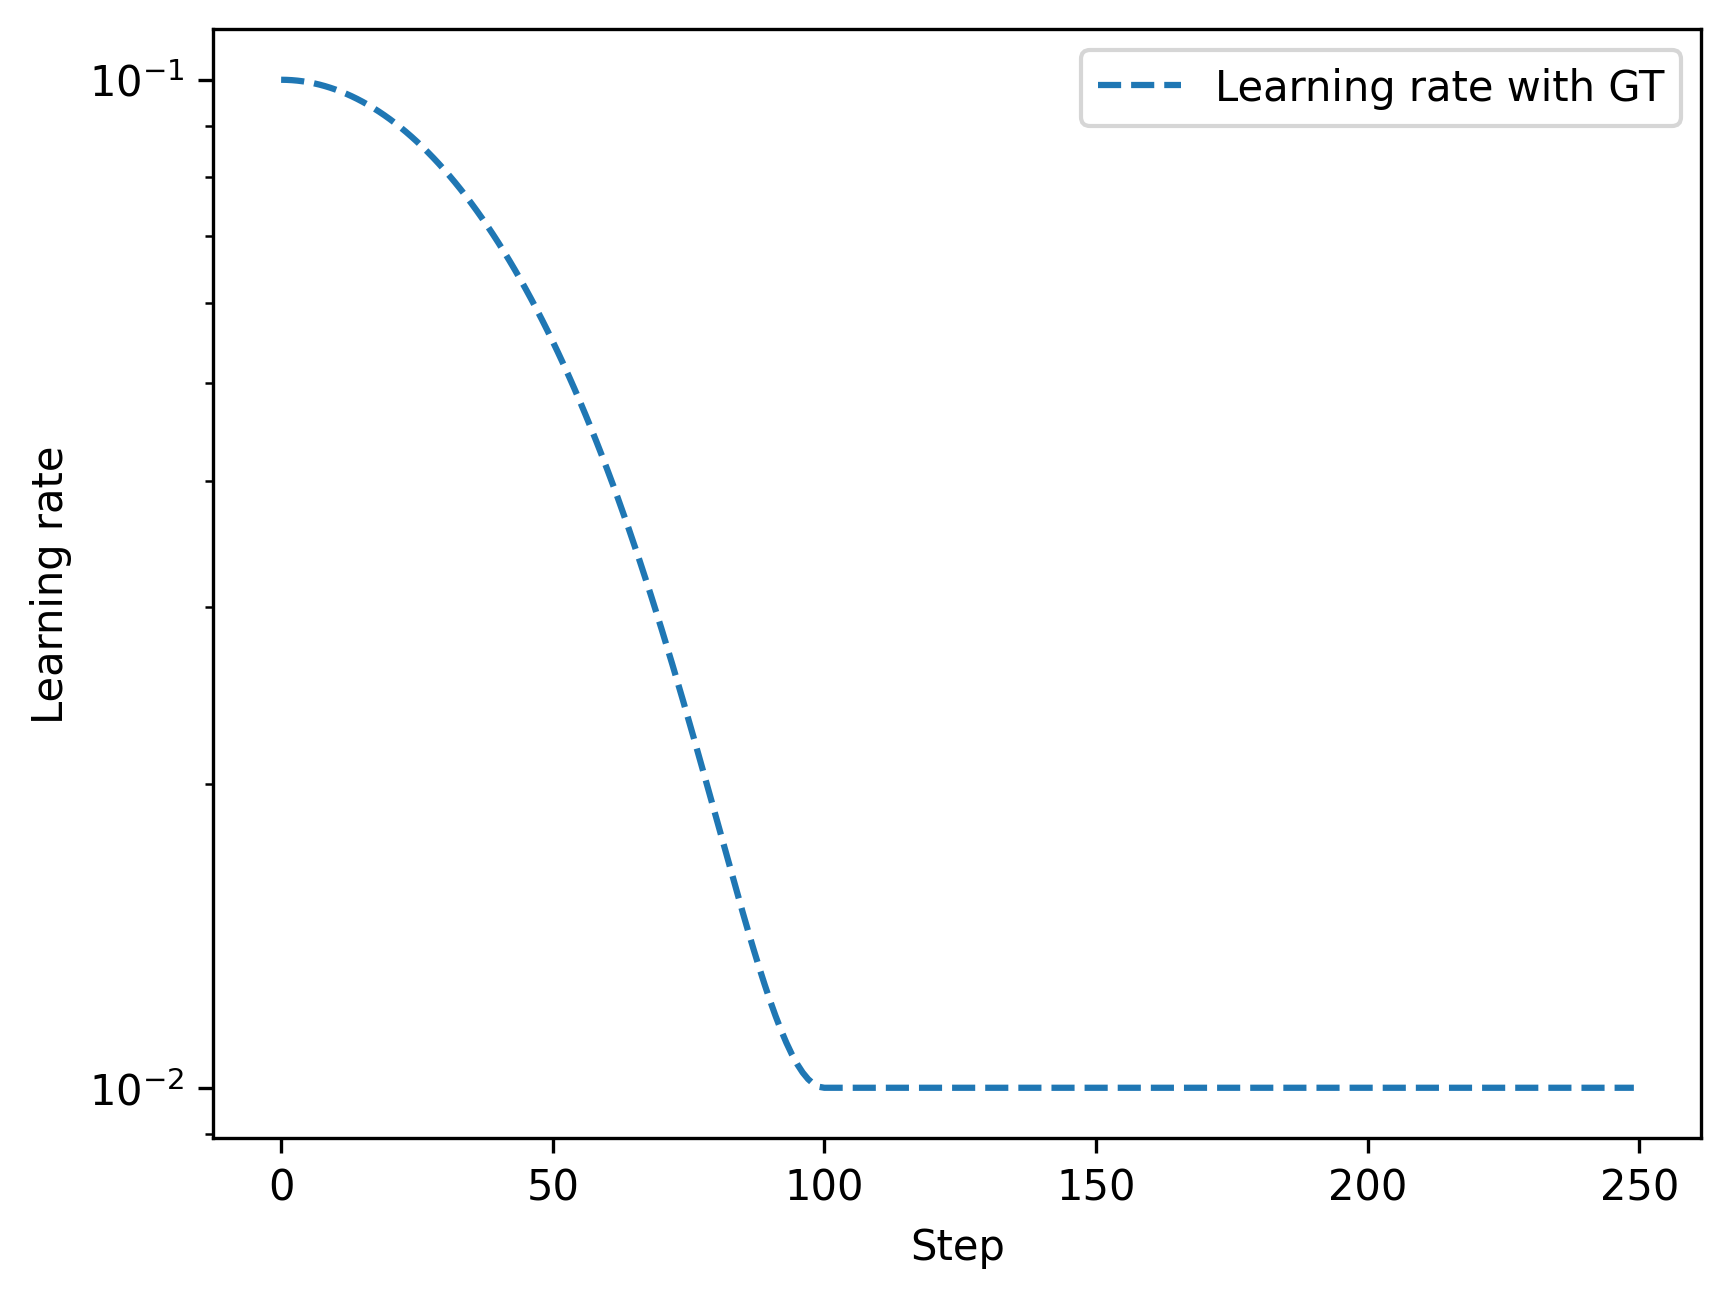

In [415]:
scheduler = optax.cosine_onecycle_schedule(transition_steps=100, peak_value=1e-1, pct_start=0., div_factor=5, final_div_factor=2)

# so here gradient_transorm is an optimizer, and it is a chain of operations that modified the gradients from adam

gradient_transform = optax.chain(
    # optax.clip_by_global_norm(1), # Clip gradients by global norm to 1.0
    optax.scale_by_adam(), # Scale gradients by Adam
    optax.scale_by_schedule(scheduler), # Scale gradients by the learning rate schedule
    # scale updates by -1 since optax.apply_updates adds updates to the parameters
    optax.scale(-1.0),
)

lrs = jax.vmap(scheduler)(jnp.arange(250))
fig = plt.figure(dpi=300)
plt.plot(lrs, label='Learning rate with GT', linestyle='--')
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.legend()
plt.show()

In [416]:
params = jnp.array([0.0, 0.0])
opt_state = gradient_transform.init(params)

ps2 = []
us2 = []


for _ in range(250):
    grads = grad(params, xs, ys)
    updates, opt_state = gradient_transform.update(grads, opt_state)
    ps2.append(params)
    us2.append(updates)
    params = optax.apply_updates(params, updates)

assert jnp.allclose(params, target_params), \
'Optimization should retrieve the target params used to generate the data.'

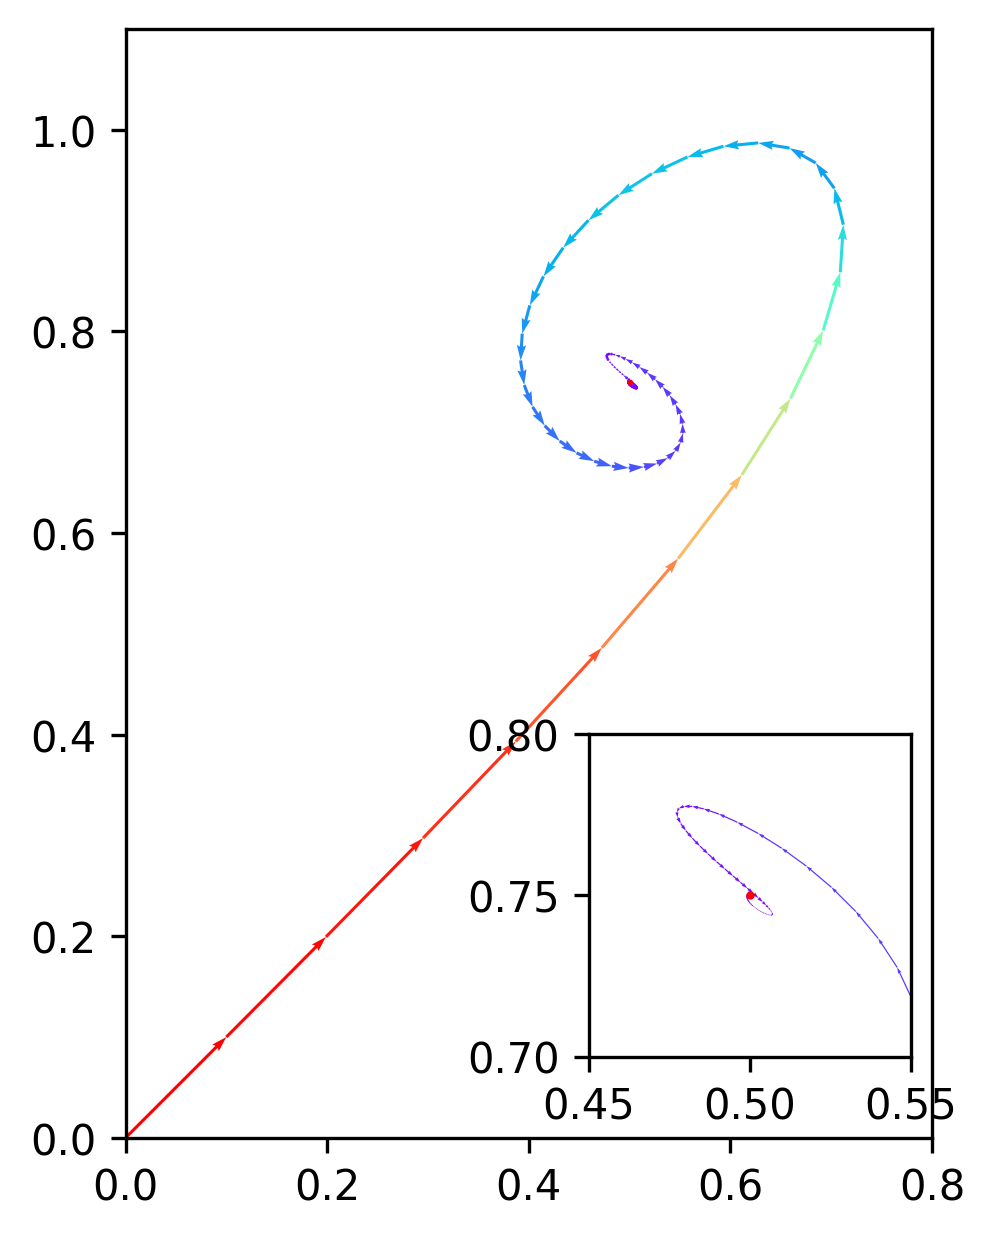

In [417]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

psp2 = jnp.array(ps2)
usp2 = jnp.array(us2)
# Calculate the magnitude of each vector
magnitudes2 = jnp.linalg.norm(usp2, axis=1)

fig2, ax = plt.subplots(dpi=300)
quiver = ax.quiver(psp2[:, 0], psp2[:, 1], usp2[:, 0], usp2[:, 1], magnitudes2, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
ax.scatter(target_params[0], target_params[1], color='red', s=0.1)
ax.set_xlim(0, 0.8)
ax.set_ylim(0, 1.1)
ax.set_aspect('equal', adjustable='box')

axins = inset_axes(ax, width="40%", height="40%", loc='lower right')
axins.quiver(psp2[:, 0], psp2[:, 1], usp2[:, 0], usp2[:, 1], magnitudes2, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
axins.scatter(target_params[0], target_params[1], color='red', s=1)
axins.set_xlim(0.45, 0.55)
axins.set_ylim(0.7, 0.8)
axins.set_aspect('equal', adjustable='box')

plt.show()

In [441]:
params = jnp.array([0.0, 0.0])

decaying_global_norm_tx = optax.inject_hyperparams(optax.clip_by_global_norm)(max_norm=optax.linear_schedule(2.0, 1.0, 250))

gradient_transform_with_linear_grad_norm = optax.chain(
    decaying_global_norm_tx,
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(scheduler),
    optax.scale(-1.0),
)

opt_state = gradient_transform_with_linear_grad_norm.init(params)


ps3 = []
us3 = []

for _ in range(250):
    grads = grad(params, xs, ys)
    updates, opt_state = gradient_transform_with_linear_grad_norm.update(grads, opt_state)
    ps3.append(params)
    us3.append(updates)
    params = optax.apply_updates(params, updates)

assert jnp.allclose(params, target_params), \
'Optimization should retrieve the target params used to generate the data.'

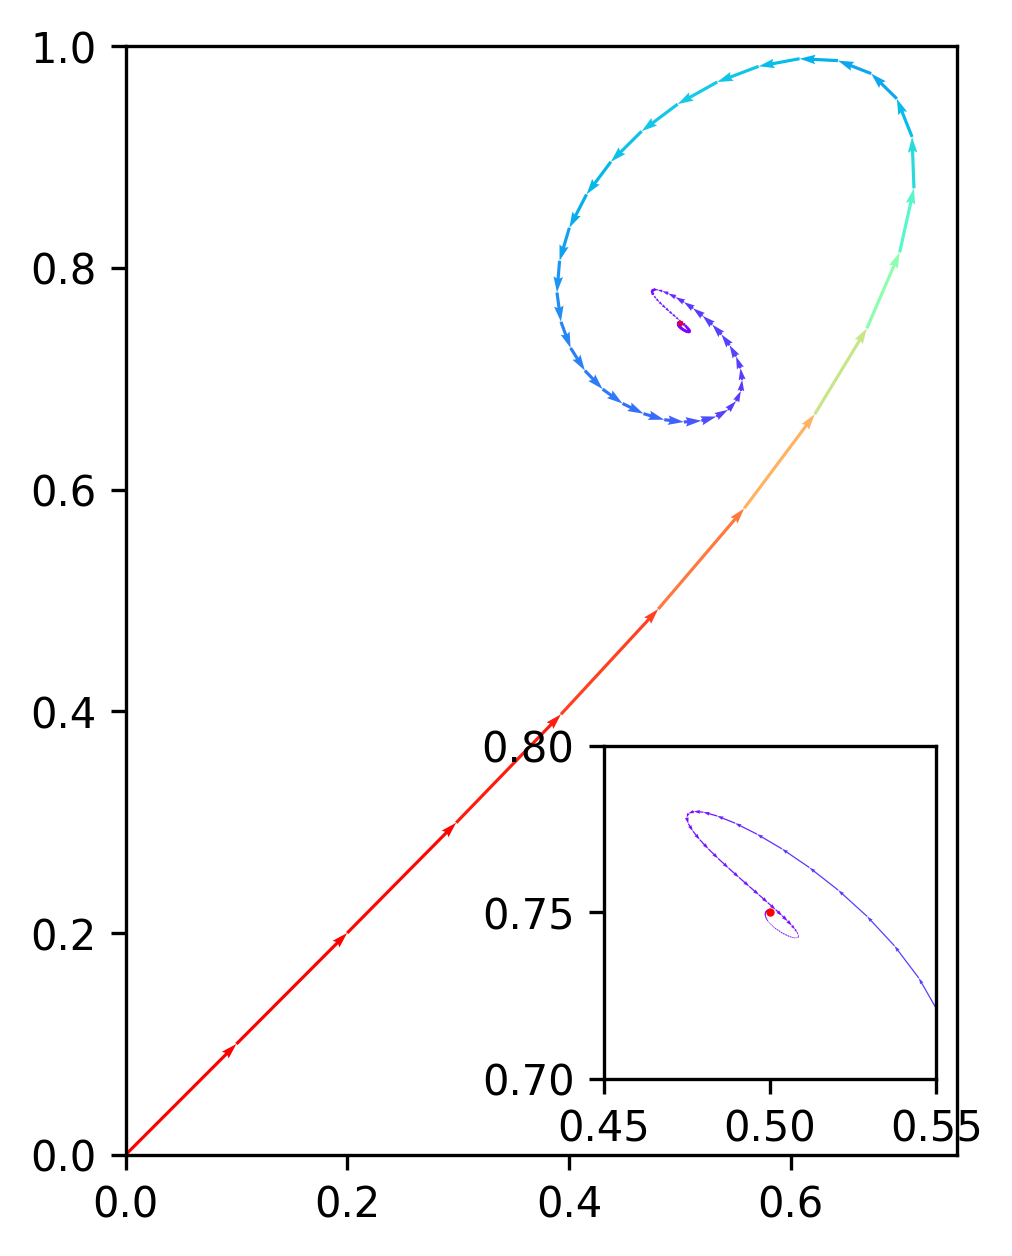

In [442]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

psp3 = jnp.array(ps3)
usp3 = jnp.array(us3)
# Calculate the magnitude of each vector
magnitudes3 = jnp.linalg.norm(usp3, axis=1)

fig2, ax = plt.subplots(dpi=300)
quiver = ax.quiver(psp3[:, 0], psp3[:, 1], usp3[:, 0], usp3[:, 1], magnitudes3, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
ax.scatter(target_params[0], target_params[1], color='red', s=0.1)
ax.set_xlim(0, 0.75)
ax.set_ylim(0, 1)
ax.set_aspect('equal', adjustable='box')

axins = inset_axes(ax, width="40%", height="40%", loc='lower right')
axins.quiver(psp3[:, 0], psp3[:, 1], usp3[:, 0], usp3[:, 1], magnitudes3, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
axins.scatter(target_params[0], target_params[1], color='red', s=1)
axins.set_xlim(0.45, 0.55)
axins.set_ylim(0.7, 0.8)
axins.set_aspect('equal', adjustable='box')

plt.show()

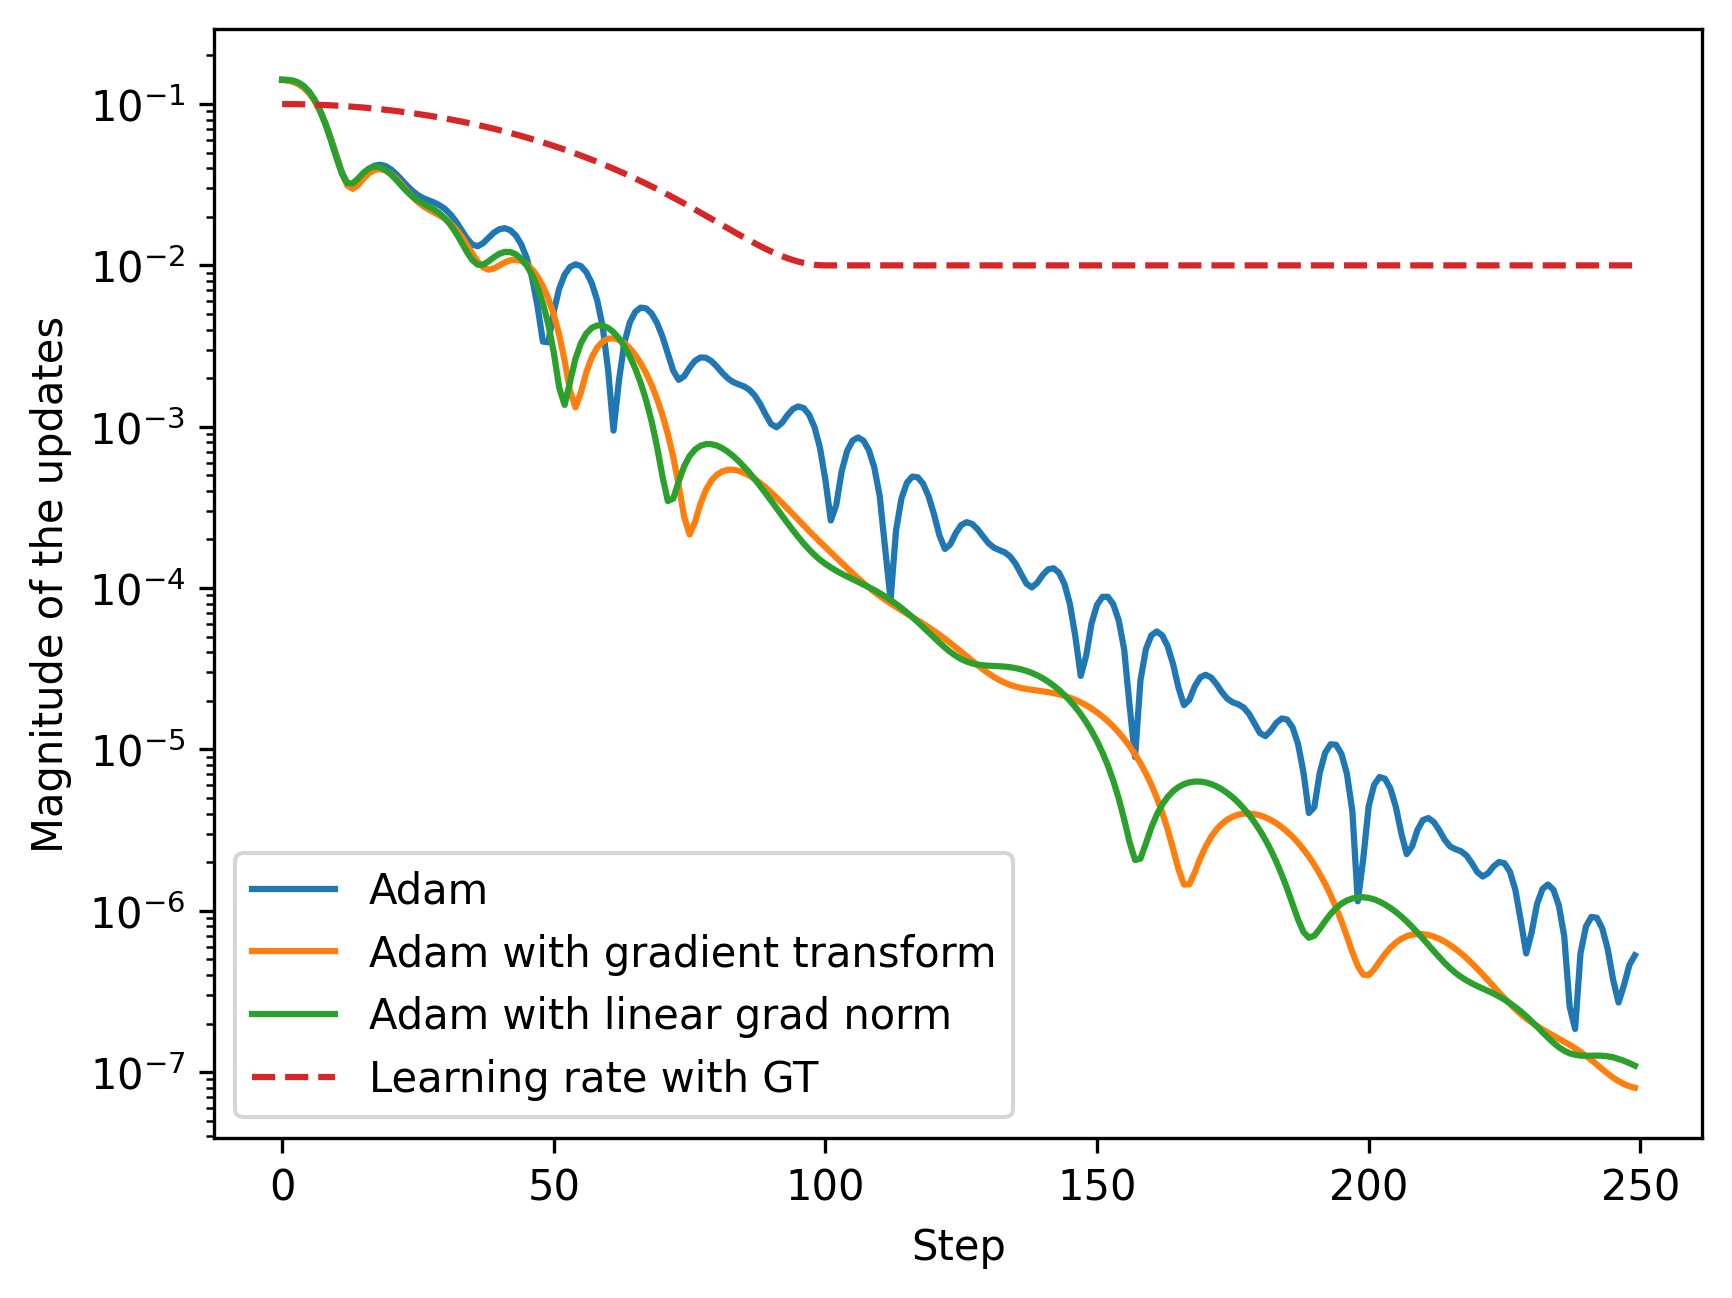

In [443]:
# plot the magnitude of the updates
fig = plt.figure(dpi=300)
plt.plot(magnitudes, label='Adam')
plt.plot(magnitudes2, label='Adam with gradient transform')
plt.plot(magnitudes3, label='Adam with linear grad norm')
lrs = jax.vmap(scheduler)(jnp.arange(250))
plt.plot(lrs, label='Learning rate with GT', linestyle='--')
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Magnitude of the updates')
plt.legend()
plt.show()

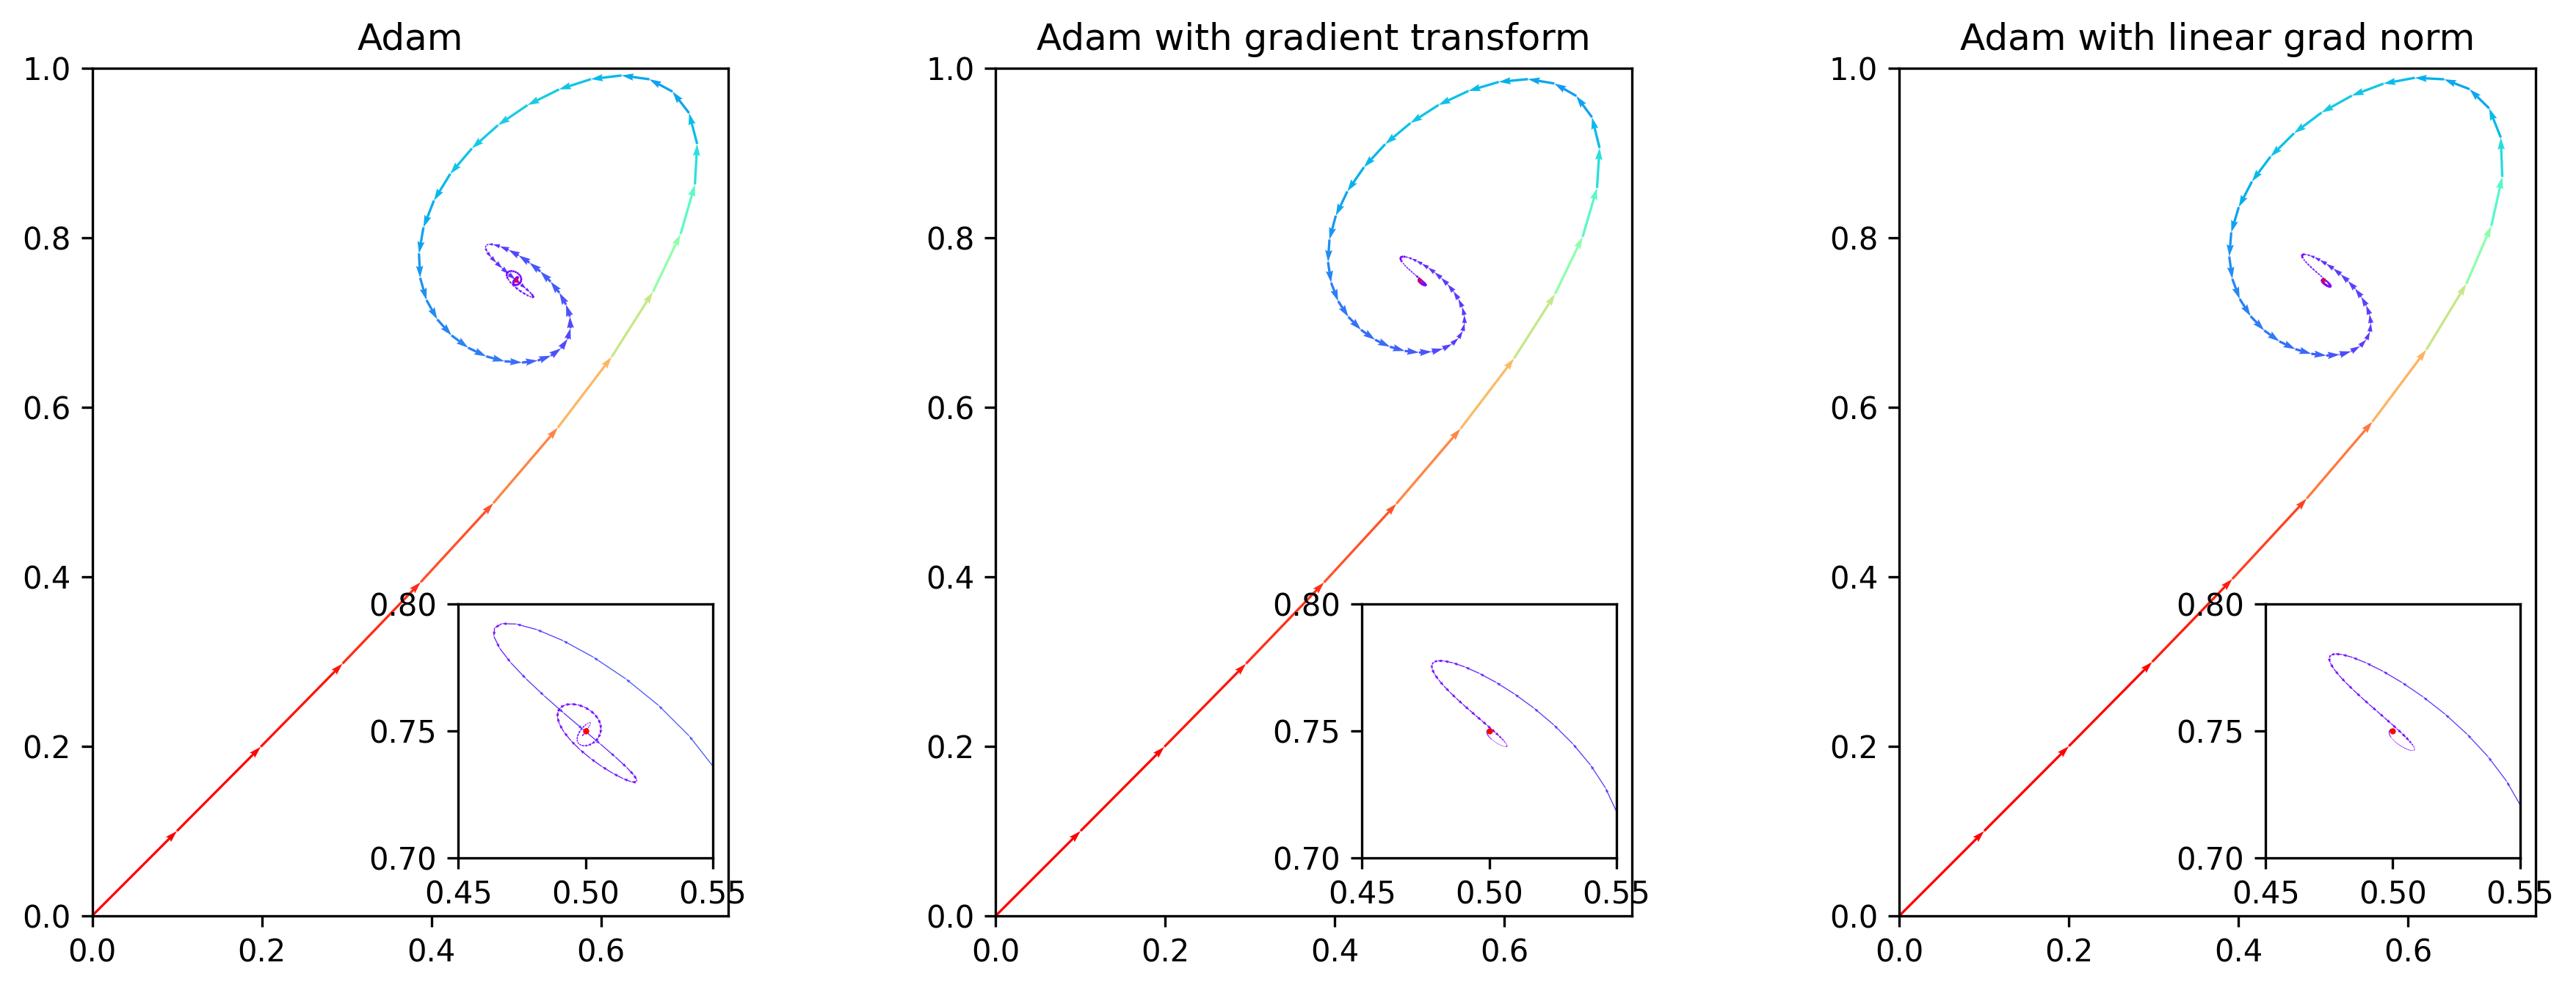

In [444]:
# combine fig1 and fig2
fig, axs = plt.subplots(1, 3, dpi=300, figsize=(15, 5))
axs[0].quiver(psp[:, 0], psp[:, 1], usp[:, 0], usp[:, 1], magnitudes, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
axs[0].scatter(target_params[0], target_params[1], color='red', s=0.1)
axs[0].set_xlim(0, 0.75)
axs[0].set_ylim(0, 1)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_title('Adam')

axs[1].quiver(psp2[:, 0], psp2[:, 1], usp2[:, 0], usp2[:, 1], magnitudes2, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
axs[1].scatter(target_params[0], target_params[1], color='red', s=0.1)
axs[1].set_xlim(0, 0.75)
axs[1].set_ylim(0, 1)
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_title('Adam with gradient transform')

axs[2].quiver(psp3[:, 0], psp3[:, 1], usp3[:, 0], usp3[:, 1], magnitudes3, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
axs[2].scatter(target_params[0], target_params[1], color='red', s=0.1)
axs[2].set_xlim(0, 0.75)
axs[2].set_ylim(0, 1)
axs[2].set_aspect('equal', adjustable='box')
axs[2].set_title('Adam with linear grad norm')

axins1 = inset_axes(axs[0], width="40%", height="40%", loc='lower right')
axins1.quiver(psp[:, 0], psp[:, 1], usp[:, 0], usp[:, 1], magnitudes, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
axins1.scatter(target_params[0], target_params[1], color='red', s=1)
axins1.set_xlim(0.45, 0.55)
axins1.set_ylim(0.7, 0.8)
axins1.set_aspect('equal', adjustable='box')

axins2 = inset_axes(axs[1], width="40%", height="40%", loc='lower right')
axins2.quiver(psp2[:, 0], psp2[:, 1], usp2[:, 0], usp2[:, 1], magnitudes2, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
axins2.scatter(target_params[0], target_params[1], color='red', s=1)
axins2.set_xlim(0.45, 0.55)
axins2.set_ylim(0.7, 0.8)
axins2.set_aspect('equal', adjustable='box')

axins3 = inset_axes(axs[2], width="40%", height="40%", loc='lower right')
axins3.quiver(psp3[:, 0], psp3[:, 1], usp3[:, 0], usp3[:, 1], magnitudes3, scale=1, scale_units='xy', angles='xy', cmap='rainbow')
axins3.scatter(target_params[0], target_params[1], color='red', s=1)
axins3.set_xlim(0.45, 0.55)
axins3.set_ylim(0.7, 0.8)
axins3.set_aspect('equal', adjustable='box')

plt.show()